# 5.1 Criação de Modelos de Machine Learning - Tunning

## Carregar dados tratados

In [43]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

import joblib

In [45]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [46]:
def split_dados(df, test_size: float = 0.2):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=42)

    return (X_treino, X_teste, y_treino, y_teste)

In [47]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


In [48]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev, target_names=["Vender", "Comprar"])
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    metric = metrics.precision_score(y_teste, y_prev)
    print("Precision: ", metric)
    print("#" * 50)
    return metric

# ML modelo

In [49]:
def definir_modelo_ml() -> dict:
    return {
            "LogisticRegression": {'modelo_base': LogisticRegression(random_state=42), 'modelo_tunado': None},
           }

In [57]:
def treinar_modelo_base(modelos, splited_dados):

    X_treino, _, y_treino, _ = splited_dados

    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)

        modelos[nome]['modelo_base'] = modelo
    
    return modelos

## Tunning do modelo

In [ ]:
def scale_data(df):
    df_scaled = StandardScaler()
    return df_scaled

In [61]:
def fit_tunning_rand_search_log_reg(X_treino, y_treino):
    print("Tunning randomized search Log Reg")

    # Create the random grid
    param = {
             "solver": ["lbfgs", "liblinear"],
             "penalty": ["l2"],
             "dual": [False],
             "C": [1.0],
             "fit_intercept": [True],
             'class_weight': [None],
             'random_state': [None],
            }

    print(param)

    rf_random = RandomizedSearchCV(estimator=LogisticRegression(max_iter=100),
                                   param_distributions=param,
                                   cv=10,
                                   verbose=0,
                                   scoring="precision",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [52]:

def run_log_reg_tunning(df, splited_dados):

    X_treino, X_teste, y_treino, y_teste = splited_dados
    
    resultado_grid = fit_tunning_rand_search_log_reg(X_treino, y_treino)

    print("Ajuste Log Reg feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [53]:
def compare_tunning(df, modelos: dict, splited_dados):

    _, X_teste, _, y_teste = splited_dados

    recalls = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        recalls[nome + '_base'] =  avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        recalls[nome + '_tunned'] = avaliar(y_teste, prev, nome + '_tunado')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
    ax.set(xlabel="Modelos", ylabel="Recall", title="Recall por Modelo")
    

In [54]:
def run_tunning_fit(df, modelos, splited_dados):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['LogisticRegression']['modelo_tunado'] = run_log_reg_tunning(df, splited_dados)

    return modelos


Tunning randomized search Log Reg
{'solver': ['lbfgs', 'liblinear'], 'penalty': ['l2'], 'dual': [False], 'C': [1.0], 'fit_intercept': [True], 'class_weight': [None], 'random_state': [None]}


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ajuste Log Reg feito
Best params {'solver': 'liblinear', 'random_state': None, 'penalty': 'l2', 'fit_intercept': True, 'dual': False, 'class_weight': None, 'C': 1.0}
Best score 0.5478796803947313
LogisticRegression_base
Reporte teste
              precision    recall  f1-score   support

      Vender       0.57      0.57      0.57       186
     Comprar       0.57      0.57      0.57       185

    accuracy                           0.57       371
   macro avg       0.57      0.57      0.57       371
weighted avg       0.57      0.57      0.57       371

(2, 2)


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

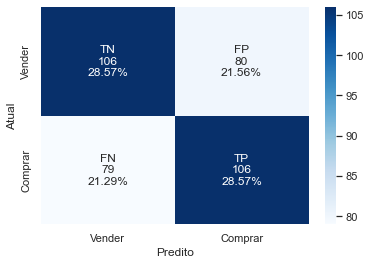

Precision:  0.5698924731182796
##################################################
LogisticRegression_tunado
Reporte teste
              precision    recall  f1-score   support

      Vender       0.54      0.57      0.55       186
     Comprar       0.54      0.51      0.52       185

    accuracy                           0.54       371
   macro avg       0.54      0.54      0.54       371
weighted avg       0.54      0.54      0.54       371

(2, 2)


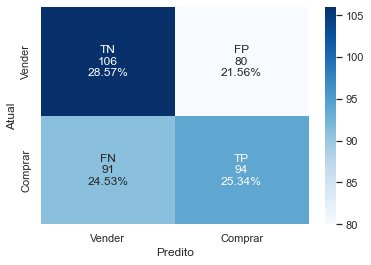

Precision:  0.5402298850574713
##################################################


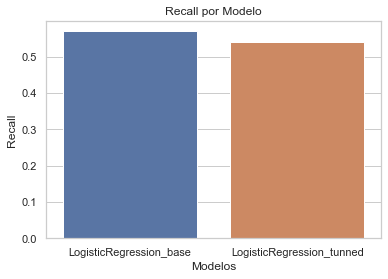

In [62]:
def main():

    df = carregar_joblib()

    modelo = definir_modelo_ml()

    splited_dados = split_dados(df)

    modelo = treinar_modelo_base(modelo, splited_dados)

    modelo = run_tunning_fit(df, modelo, splited_dados)

    compare_tunning(df, modelo, splited_dados)

    return df, modelo, splited_dados

df, modelos, splited_dados = main()